In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, recall_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.ensemble import RandomForestClassifier

In [2]:
data = pd.read_csv('/datasets/Churn.csv')

In [3]:
data.shape

(10000, 14)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [5]:
data.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


In [6]:
data.isna().sum()

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

In [7]:
#Replacing the missing values with the mean
mean = data['Tenure'].mean().round(2)

data['Tenure'].fillna(mean, inplace=True)

In [8]:
data.duplicated().sum()

0

In [9]:
data['Geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

In [10]:
#Using one hot enoding for the categorical columns
data_ohe = pd.get_dummies(data, columns=['Gender', 'Geography'], drop_first=True)

In [11]:
#Applying label encoding 
encoder = OrdinalEncoder()

for col in ['Geography', 'Gender']:
    data[[col]] = encoder.fit_transform(data[[col]])

I created to datasets to deal with categorical values and will see whichever gives me higher F1 score.

In [12]:
#Determining features and target
x = data.drop(['RowNumber', 'CustomerId', 'Surname', 'Exited'], axis=1)
y = data['Exited']

In [13]:
#Diving the dataset into main and test sets
test_size = 0.20
x_main, x_test, y_main, y_test=train_test_split(x,y, test_size=test_size, random_state=12345, stratify=y)

In [14]:
#Dividing the main set into train and validation sets
valid_size = 0.20
x_train, x_valid, y_train, y_valid=train_test_split(x_main,y_main, test_size=valid_size, random_state=12345, stratify=y_main)

<AxesSubplot:title={'center':'Class Distribution'}, xlabel='Exited'>

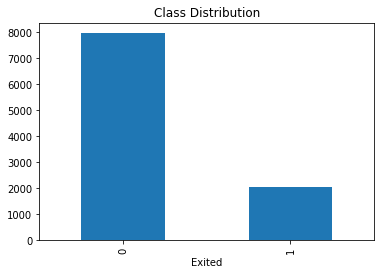

In [15]:
#FInding the balance of target values
data.pivot_table(index='Exited', aggfunc='size')\
    .plot(kind='bar', title = 'Class Distribution')

In [16]:
data['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

In [17]:
#Scaling all the columns
scaler = StandardScaler()

numeric=['CreditScore','Age','Geography','Gender','HasCrCard','IsActiveMember','Tenure','Balance','NumOfProducts','EstimatedSalary']
x_scaled = x_train[numeric]
x_v_scaled = x_valid[numeric]
x_t_scaled = x_test[numeric]

scaler.fit(x_scaled)

x_scaled= scaler.transform(x_scaled)
x_v_scaled = scaler.transform(x_v_scaled)
x_t_scaled = scaler.transform(x_t_scaled)

In [18]:
model = DecisionTreeClassifier(random_state=12345)

In [19]:
#Training the model 
model.fit(x_train, y_train)

DecisionTreeClassifier(random_state=12345)

In [20]:
#Finding the predicted values to calculte f1 score
y_pred = model.predict(x_valid)

In [21]:
print('F1 Score:',f1_score(y_valid, y_pred))

F1 Score: 0.47416413373860183


In [22]:
#Upsampling to deal with imbalance of the classes
def upsample(x, y, repeat):
    x_zeros = x[y == 0]
    x_ones = x[y == 1]
    y_zeros = y[y == 0]
    y_ones = y[y == 1]

    x_upsampled = pd.concat([x_zeros] + ([x_ones] * repeat))
    y_upsampled = pd.concat([y_zeros] + ([y_ones] * repeat))

    x_upsampled, y_upsampled = shuffle(
        x_upsampled, y_upsampled, random_state=12345)

    return x_upsampled, y_upsampled

x_upsampled, y_upsampled = upsample(x_train, y_train, 4)

In [23]:
best_score = 0
best_est = 0
for est in range(1, 30):
    model_ran = RandomForestClassifier(random_state=12345, n_estimators=est)
    model_ran.fit(x_upsampled,y_upsampled)
    predictions_valid = model_ran.predict(x_valid)
    score = f1_score(y_valid,predictions_valid) 
    if score > best_score:
        best_score = score
        best_est = est

print("Accuracy of the best model on the validation set (n_estimators = {}): {}".format(best_est, best_score))

Accuracy of the best model on the validation set (n_estimators = 23): 0.61


In [24]:
#Finding the F1 score of upsampled model
model_up = RandomForestClassifier(random_state=12345, n_estimators=23)
model_up.fit(x_upsampled, y_upsampled)
predictions_valid = model_up.predict(x_valid)

print('F1 Score:', f1_score(y_valid, predictions_valid))

F1 Score: 0.61


In [25]:
probabilities_valid = model_up.predict_proba(x_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print('AUC-ROC score:',roc_auc_score(y_valid, probabilities_one_valid))



AUC-ROC score: 0.8361941520355192


In [26]:
#Downsampling to deal with imbalance of the classes
def downsample(x, y, fraction):
    x_zeros = x[y == 0]
    x_ones = x[y == 1]
    y_zeros = y[y == 0]
    y_ones = y[y == 1]

    x_downsampled = pd.concat(
        [x_zeros.sample(frac=fraction, random_state=12345)] + [x_ones])
    
    y_downsampled = pd.concat(
        [y_zeros.sample(frac=fraction, random_state=12345)] + [y_ones])

    x_downsampled, y_downsampled = shuffle(
        x_downsampled, y_downsampled, random_state=12345)

    return x_downsampled, y_downsampled


x_downsampled, y_downsampled = downsample(x_train, y_train, 0.25)

In [27]:
best_score = 0
best_est = 0
for est in range(1, 30):
    model_random = RandomForestClassifier(random_state=12345, n_estimators=est)
    model_random.fit(x_downsampled,y_downsampled)
    predictions_valid = model_random.predict(x_valid)
    score = f1_score(y_valid,predictions_valid) 
    if score > best_score:
        best_score = score
        best_est = est

print("Accuracy of the best model on the validation set (n_estimators = {}): {}".format(best_est, best_score))

Accuracy of the best model on the validation set (n_estimators = 16): 0.5822784810126582


In [28]:
#Finding the F1 score of downsampled model
model_down = RandomForestClassifier(random_state=12345, n_estimators=16)
model_down.fit(x_downsampled, y_downsampled)
prediction_valid = model_down.predict(x_valid)

print('F1 Score:', f1_score(y_valid, prediction_valid))

F1 Score: 0.5822784810126582


In [29]:
probabilities_valid = model_down.predict_proba(x_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print('AUC-ROC score:',roc_auc_score(y_valid, probabilities_one_valid))

AUC-ROC score: 0.8319251957507873


In [31]:
x_main_upsampled, y_main_upsampled = upsample(x_main, y_main, 4)

In [32]:
#Finding the F1 score of the test set
final_model = RandomForestClassifier(random_state=12345, n_estimators=33)
final_model.fit(x_main_upsampled, y_main_upsampled)
predicted_test = final_model.predict(x_test)
print('F1 Score:', f1_score(y_test,predicted_test))

F1 Score: 0.5904255319148937


In [33]:
#Finding AUC-ROC value
probabilities_valid = final_model.predict_proba(x_test)
probabilities_one_valid = probabilities_valid[:, 1]

print('AUC-ROC score:',roc_auc_score(y_test, probabilities_one_valid))

AUC-ROC score: 0.8543289051763627


Trying Class Weight Adjustment

In [34]:
model_2 = LogisticRegression(random_state=12345, solver='liblinear', class_weight = 'balanced')

In [35]:
model_2.fit(x_train, y_train)

LogisticRegression(class_weight='balanced', random_state=12345,
                   solver='liblinear')

In [36]:
pred_2 = model_2.predict(x_valid)

In [37]:
print('F1 Score:',f1_score(y_valid, pred_2))

F1 Score: 0.4890738813735693


In [38]:
probabilities_valid = model_2.predict_proba(x_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print('AUC-ROC score:',roc_auc_score(y_valid, probabilities_one_valid))

AUC-ROC score: 0.771224393485568


### Conclusion


I prepared the data by replacing the missing values in the tenure column with the mean,checking for duplicates, and scaling the dataset. To deal with the categorical values, I created 2 datasets using one-hot encoding and label encoding to see whichever worked the best. I picked the logistic regression model and trained it. To deal with the imbalance I applied both upsample and downsample methods as well as class weight adjustment. Best model was found to be random forest with 28 estimators. F1 score and AUC-ROC scores were determined.